In [1]:
import pandas as pd
import numpy as np

In [2]:
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


Pode ser um "azar" como pode ser uma proporção de exemplos desbalanceados entre as classes.

In [3]:
dados_azar = dados.sort_values("vendido")
X_azar = dados_azar.filter(["preco","idade_do_modelo","km_por_ano"])
y_azar = dados_azar.vendido
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [4]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, X_azar, y_azar, cv=10)
media = results["test_score"].mean()
desvio_padrao = results["test_score"].std()
print(f"Acurácia do Dummy com 10-fold Cross-Validation [{(media - 2 * desvio_padrao) * 100:0.2f}, {(media + 2 * desvio_padrao) * 100:0.2f}]")

Acurácia do Dummy com 10-fold Cross-Validation [58.00, 58.00]


In [5]:
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, X_azar, y_azar, cv=10)
media = results["test_score"].mean()
desvio_padrao = results["test_score"].std()
print(f"Acurácia do DecisionTreeClassifier com 10-fold Cross-Validation [{(media - 2 * desvio_padrao) * 100:0.2f}, {(media + 2 * desvio_padrao) * 100:0.2f}]")

Acurácia do DecisionTreeClassifier com 10-fold Cross-Validation [73.83, 77.73]


Gerando dados aleatórios de modelo de carro para simulação de agrupamento ao usar nosso estimador.

In [6]:
np.random.seed(SEED)
dados["modelo"] = dados.idade_do_modelo + np.random.randint(-2, 3, size=len(dados))
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [7]:
def imprime_resultados(results):
    media = results["test_score"].mean()
    desvio_padrao = results["test_score"].std()
    print(f"Acurácia {media * 100:0.2f}")
    print(f"Acurácia com Cross-Validation = [{(media - 2 * desvio_padrao) * 100:0.2f}, {(media + 2 * desvio_padrao) * 100:0.2f}]")

GroupKFold em um pipeline com StandardScaler e SVC.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold


SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([("transformacao", scaler), ("estimador", modelo)])

cv = GroupKFold(n_splits=10)
results = cross_validate(pipeline, X_azar, y_azar, cv=cv, groups=dados.modelo)
imprime_resultados(results)

Acurácia 76.68
Acurácia com Cross-Validation = [74.28, 79.08]


GroupKFold para analisar como o modelo se comporta com novos grupos.

In [9]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, X_azar, y_azar, cv=cv, groups=dados.modelo)
imprime_resultados(results)

Acurácia 75.78
Acurácia com Cross-Validation = [73.67, 77.90]


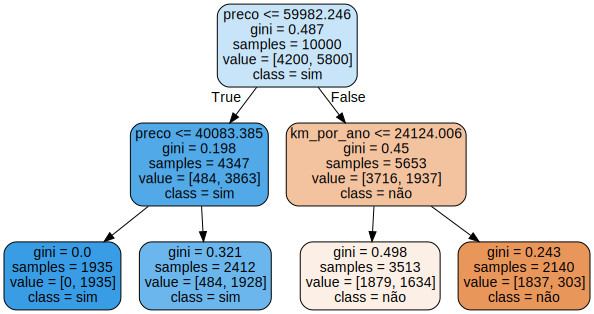

In [10]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(X_azar, y_azar)
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names=X_azar.columns)
graph = graphviz.Source(dot_data)
graph

In [11]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, X_azar, y_azar, cv=cv, groups=dados.modelo)
imprime_resultados(results)

Acurácia 78.67
Acurácia com Cross-Validation = [76.40, 80.94]


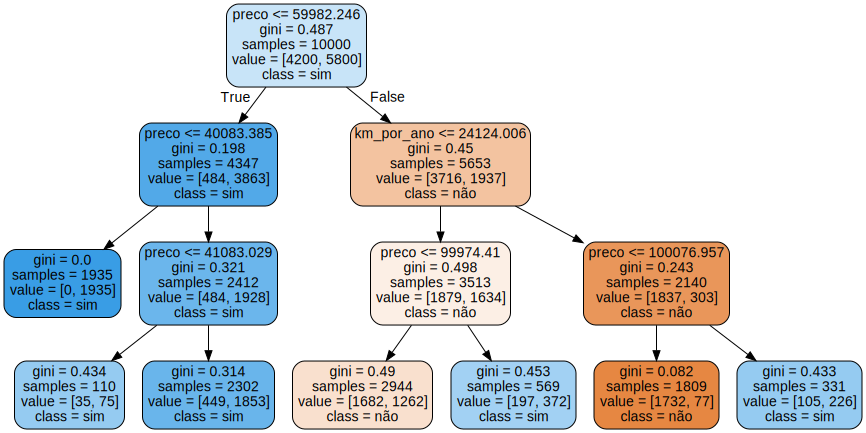

In [12]:
modelo.fit(X_azar, y_azar)
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names=X_azar.columns)
graph = graphviz.Source(dot_data)
graph

In [13]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, X_azar, y_azar, cv=cv, groups=dados.modelo)
imprime_resultados(results)

Acurácia 77.19
Acurácia com Cross-Validation = [75.26, 79.13]


# Explorando hiperparâmetros em 1 dimensão

In [14]:
def roda_arvore_de_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, X_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=True)
    media_treino = results['train_score'].mean() * 100
    media_teste = results['test_score'].mean() * 100
    print(f"Árvore max_depth = {max_depth}, treino = {media_treino:0.2f}%, teste = {media_teste:0.2f}%")
    tabela = [max_depth, media_treino, media_teste]
    return tabela

resultados = [roda_arvore_de_decisao(i) for i in range(1, 33)]
resultados = pd.DataFrame(resultados, columns=["max_depth", "media_treino", "media_teste"])
resultados.head()

Árvore max_depth = 1, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, treino = 75.79%, teste = 75.78%
Árvore max_depth = 3, treino = 78.75%, teste = 78.67%
Árvore max_depth = 4, treino = 78.79%, teste = 78.63%
Árvore max_depth = 5, treino = 78.94%, teste = 78.56%
Árvore max_depth = 6, treino = 79.17%, teste = 78.12%
Árvore max_depth = 7, treino = 79.50%, teste = 77.96%
Árvore max_depth = 8, treino = 79.89%, teste = 77.86%
Árvore max_depth = 9, treino = 80.46%, teste = 77.38%
Árvore max_depth = 10, treino = 81.16%, teste = 77.19%
Árvore max_depth = 11, treino = 82.03%, teste = 76.97%
Árvore max_depth = 12, treino = 82.89%, teste = 76.49%
Árvore max_depth = 13, treino = 83.95%, teste = 75.81%
Árvore max_depth = 14, treino = 85.03%, teste = 75.66%
Árvore max_depth = 15, treino = 86.14%, teste = 75.16%
Árvore max_depth = 16, treino = 87.19%, teste = 75.11%
Árvore max_depth = 17, treino = 88.31%, teste = 74.74%
Árvore max_depth = 18, treino = 89.26%, teste = 74.33%
Árvore max_depth = 

,max_depth,media_treino,media_teste
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


# OVERFIT: ficou "perfeito" para o treino, mas ruim para o teste

<AxesSubplot:xlabel='max_depth', ylabel='media_treino'>

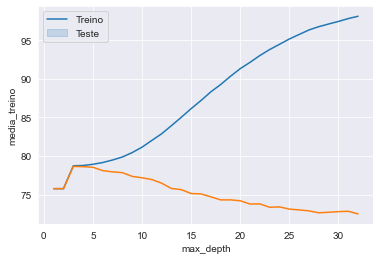

In [15]:
import seaborn as sns

ax = sns.lineplot(x="max_depth", y="media_treino", data=resultados)
ax = sns.lineplot(x="max_depth", y="media_teste", data=resultados)
ax.legend(["Treino", "Teste"])
ax

In [16]:
resultados.sort_values("media_teste", ascending=False).head()

,max_depth,media_treino,media_teste
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


# Explorando hiperparâmetros em 2 dimensões

In [17]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    results = cross_validate(modelo, X_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=True)
    media_treino = results['train_score'].mean() * 100
    media_teste = results['test_score'].mean() * 100
    print(f"Árvore max_depth = {max_depth}, min_samples_leaf = {min_samples_leaf}, treino = {media_treino:0.2f}%, teste = {media_teste:0.2f}%")
    tabela = [max_depth, min_samples_leaf, media_treino, media_teste]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)

    resultados = pd.DataFrame(resultados, columns=["max_depth", "min_samples_leaf", "media_treino", "media_teste"])
    return resultados

resultados = busca()

Árvore max_depth = 1, min_samples_leaf = 32, treino = 75.79%, teste = 75.78%
Árvore max_depth = 1, min_samples_leaf = 64, treino = 75.79%, teste = 75.78%
Árvore max_depth = 1, min_samples_leaf = 128, treino = 75.79%, teste = 75.78%
Árvore max_depth = 1, min_samples_leaf = 256, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, min_samples_leaf = 32, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, min_samples_leaf = 64, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, min_samples_leaf = 128, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, min_samples_leaf = 256, treino = 75.79%, teste = 75.78%
Árvore max_depth = 3, min_samples_leaf = 32, treino = 78.75%, teste = 78.67%
Árvore max_depth = 3, min_samples_leaf = 64, treino = 78.75%, teste = 78.67%
Árvore max_depth = 3, min_samples_leaf = 128, treino = 78.75%, teste = 78.67%
Árvore max_depth = 3, min_samples_leaf = 256, treino = 78.75%, teste = 78.67%
Árvore max_depth = 4, min_samples_leaf = 32, treino = 78.75%, teste = 

In [18]:
resultados.sort_values("media_teste", ascending=False).head()

,max_depth,min_samples_leaf,media_treino,media_teste
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


In [19]:
corr = resultados.corr()

<AxesSubplot:>

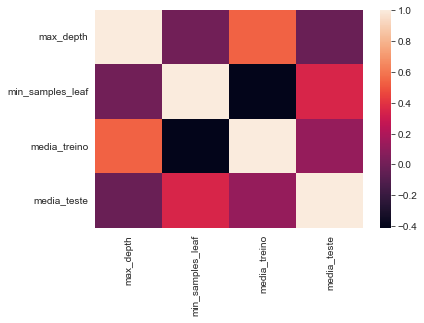

In [20]:
sns.heatmap(corr)

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot:xlabel='media_treino', ylabel='max_depth'>,
        <AxesSubplot:xlabel='media_teste', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='media_treino', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='media_teste', ylabel='min_samples_leaf'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='media_treino'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='media_treino'>,
        <AxesSubplot:xlabel='media_treino', ylabel='media_treino'>,
        <AxesSubplot:xlabel='media_teste', ylabel='media_treino'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='media_teste'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='media_teste'>,
        <AxesSubplot:xlabel='media_treino'

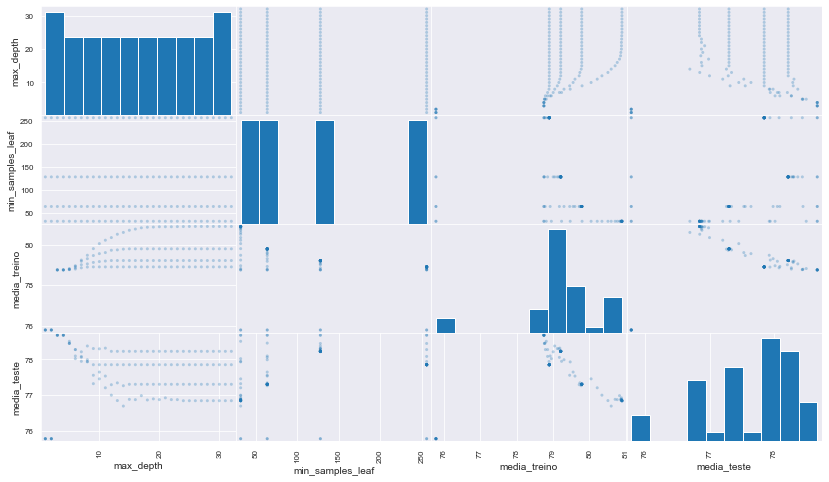

In [21]:
pd.plotting.scatter_matrix(resultados, figsize=(14, 8), alpha=0.3)

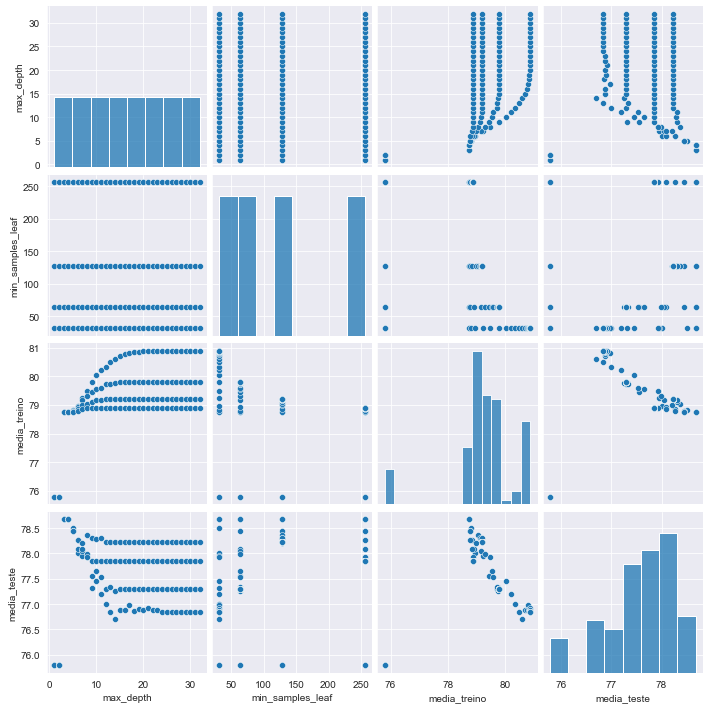

In [22]:
sns.pairplot(resultados)

<AxesSubplot:>

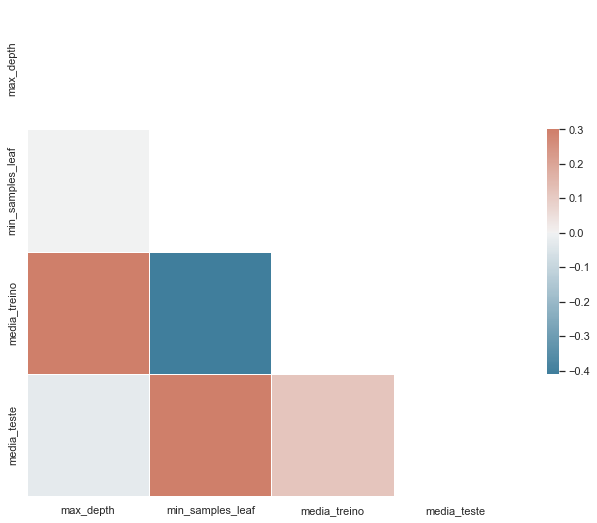

In [23]:
from string import ascii_letters
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [24]:
def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [128, 192, 256, 512]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)

    resultados = pd.DataFrame(resultados, columns=["max_depth", "min_samples_leaf", "media_treino", "media_teste"])
    return resultados

resultados = busca()

Árvore max_depth = 1, min_samples_leaf = 128, treino = 75.79%, teste = 75.78%
Árvore max_depth = 1, min_samples_leaf = 192, treino = 75.79%, teste = 75.78%
Árvore max_depth = 1, min_samples_leaf = 256, treino = 75.79%, teste = 75.78%
Árvore max_depth = 1, min_samples_leaf = 512, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, min_samples_leaf = 128, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, min_samples_leaf = 192, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, min_samples_leaf = 256, treino = 75.79%, teste = 75.78%
Árvore max_depth = 2, min_samples_leaf = 512, treino = 75.79%, teste = 75.78%
Árvore max_depth = 3, min_samples_leaf = 128, treino = 78.75%, teste = 78.67%
Árvore max_depth = 3, min_samples_leaf = 192, treino = 78.75%, teste = 78.67%
Árvore max_depth = 3, min_samples_leaf = 256, treino = 78.75%, teste = 78.67%
Árvore max_depth = 3, min_samples_leaf = 512, treino = 77.53%, teste = 77.50%
Árvore max_depth = 4, min_samples_leaf = 128, treino = 78.75%, t

In [25]:
corr = resultados.corr()

<AxesSubplot:>

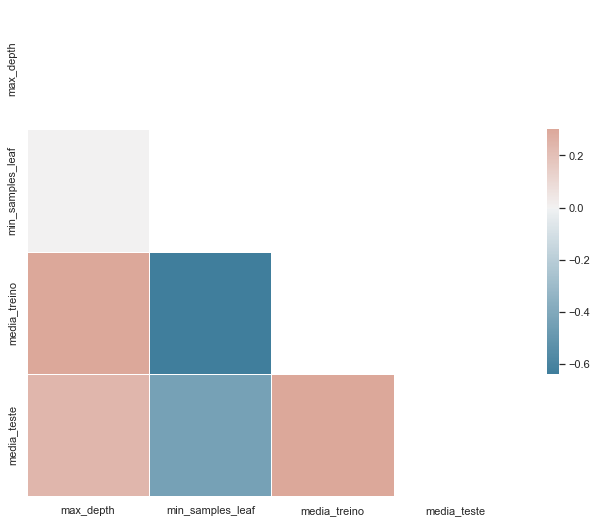

In [26]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [27]:
resultados.sort_values("media_teste", ascending=False).head()

,max_depth,min_samples_leaf,media_treino,media_teste
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


# Explorando hiperparâmetros em 3 dimensões

In [28]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    results = cross_validate(modelo, X_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=True)
    media_treino = results['train_score'].mean() * 100
    media_teste = results['test_score'].mean() * 100
    media_tempo_treino = results["fit_time"].mean() * 100 # tempo de treino
    media_tempo_teste = results["score_time"].mean() * 100 # tempo de teste
    tabela = [max_depth, min_samples_leaf, min_samples_split, media_treino, media_teste, media_tempo_treino, media_tempo_teste]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)

    resultados = pd.DataFrame(resultados, columns=["max_depth", "min_samples_leaf", "min_samples_split", "media_treino", "media_teste", "media_tempo_treino", "media_tempo_teste"])
    return resultados

resultados = busca()

In [29]:
corr = resultados.corr()

<AxesSubplot:>

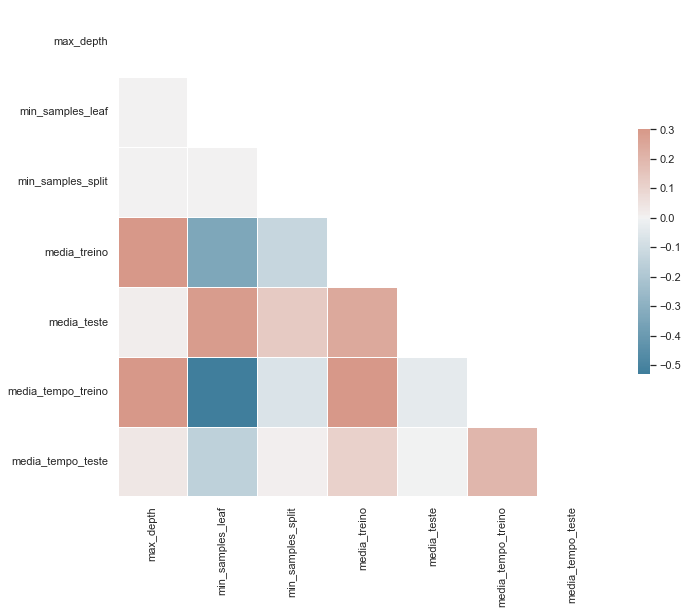

In [30]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [31]:
resultados.sort_values("media_teste", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,media_treino,media_teste,media_tempo_treino,media_tempo_teste
63,4,256,256,78.750993,78.672633,0.989711,0.159943
48,4,32,32,78.750993,78.672633,1.039677,0.149968
34,3,32,128,78.750993,78.672633,0.899725,0.179954
35,3,32,256,78.750993,78.672633,0.959692,0.179944
36,3,64,32,78.750993,78.672633,1.009645,0.159979


# Explorando espaço de hiperparâmetros com GridSearchCV

In [32]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(), espaco_parametros, cv=GroupKFold(n_splits=10))
busca.fit(X_azar, y_azar, groups=dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008897,0.000538,0.001799,0.000400,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.008698,0.000459,0.001799,0.000400,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.008798,0.000400,0.001399,0.000489,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.008798,0.000399,0.001499,0.000500,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.012196,0.005380,0.002299,0.001486,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [33]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [34]:
melhor_modelo = busca.best_estimator_
melhor_modelo

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [35]:
from sklearn.metrics import accuracy_score

# evitar essa abordagem, pois estará sendo otimista
predicoes = melhor_modelo.predict(X_azar)
acuracia = accuracy_score(y_azar, predicoes) * 100
print(f"Acurácia para os dados foi {acuracia:0.2f}%")

Acurácia para os dados foi 78.75%


# Como ter uma estimativa sem esse vício nos dados já vistos?

No caso de cross validation com busca de hiperparâmetros, fazemos, após, uma nova validação cruzada. Chama-se nested cross validation.

In [36]:
# from sklearn.model_selection import cross_val_score
#
# scores = cross_val_score(busca, X_azar, y_azar, cv=GroupKFold(n_splits=10), groups=dados.modelo)

Obs.: infelizmente, como o scikit-learn não suporta nested cross validation com GroupKFold (bug), não é possível prever o resultado para novos grupos.

In [37]:
from sklearn.model_selection import KFold

SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(), espaco_parametros, cv=KFold(n_splits=5, shuffle=True))
busca.fit(X_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009797,0.001832,0.002400,0.001019,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.007398,0.000489,0.001799,0.000400,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.007598,0.000490,0.001800,0.000400,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.009996,0.000633,0.002199,0.000400,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.008997,0.002529,0.001400,0.000490,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [38]:
from sklearn.model_selection import cross_val_score

SEED = 301
np.random.seed(SEED)

scores = cross_val_score(busca, X_azar, y_azar, cv=KFold(n_splits=10, shuffle=True))
scores

array([0.767, 0.801, 0.778, 0.774, 0.813, 0.792, 0.796, 0.79 , 0.78 ,
       0.779])

In [39]:
def imprime_score(scores):
    media = scores.mean()
    desvio_padrao = scores.std()
    print(f"Acurácia média {media * 100:0.2f}")
    print(f"Intervalo = [{(media - 2 * desvio_padrao) * 100:0.2f}, {(media + 2 * desvio_padrao) * 100:0.2f}]")

In [40]:
imprime_score(scores)

Acurácia média 78.70
Intervalo = [76.05, 81.35]


In [41]:
melhor_modelo = busca.best_estimator_
print(melhor_modelo)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


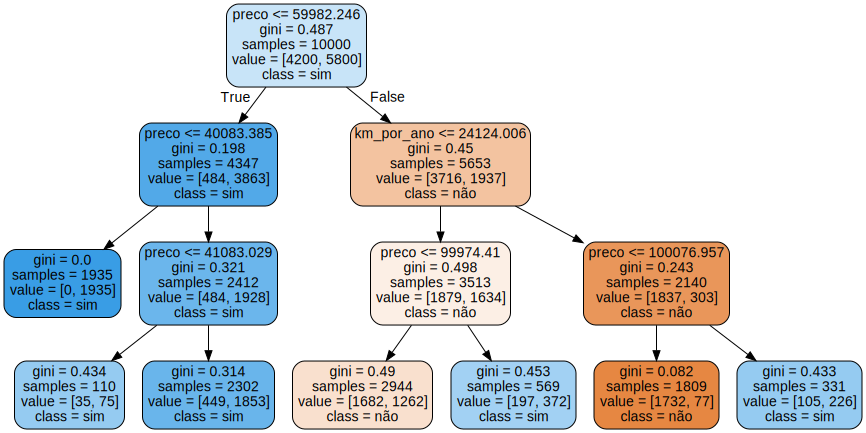

In [42]:
dot_data = export_graphviz(melhor_modelo, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names=X_azar.columns)
graph = graphviz.Source(dot_data)
graph

# Busca aleatória: RandomizedSearch

In [43]:
from sklearn.model_selection import RandomizedSearchCV

SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_parametros, n_iter= 16, cv=KFold(n_splits=5, shuffle=True), random_state=SEED)
busca.fit(X_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013995,0.002529,0.002399,4.898629e-04,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.784,0.769,0.7985,0.793,0.7730,0.7835,0.011278,13
1,0.010796,0.000748,0.002400,4.899602e-04,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
2,0.009798,0.000399,0.001999,8.662177e-07,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
3,0.019586,0.001733,0.002600,4.895315e-04,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7
4,0.017994,0.001095,0.002000,7.136645e-07,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7


In [44]:
scores = cross_val_score(busca, X_azar, y_azar, cv=KFold(n_splits=10, shuffle=True))
imprime_score(scores)

Acurácia média 78.70
Intervalo = [76.70, 80.70]


In [45]:
melhor_modelo = busca.best_estimator_
print(melhor_modelo)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=64)


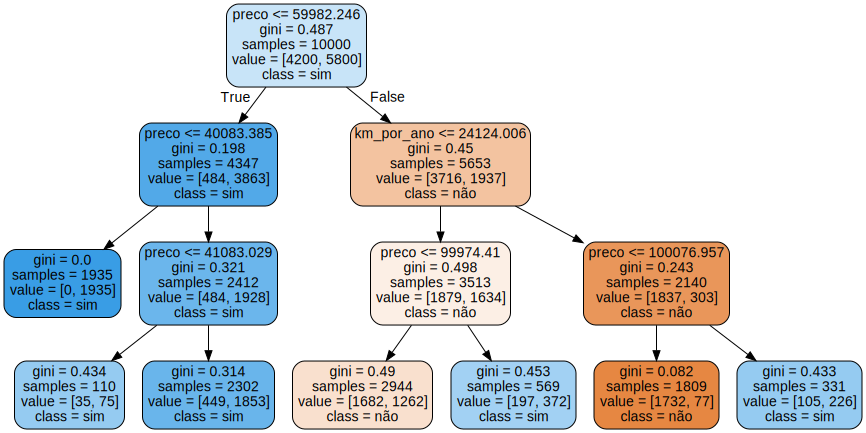

In [46]:
dot_data = export_graphviz(melhor_modelo, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names=X_azar.columns)
graph = graphviz.Source(dot_data)
graph

# Personalizando o espaço de hiperparâmetros

In [47]:
from scipy.stats import randint

SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "max_depth": [3, 5, 10, 15, 20, 30, None],
    "min_samples_split": randint(32, 128),
    "min_samples_leaf": randint(32, 128),
    "criterion": ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_parametros, n_iter= 16, cv=KFold(n_splits=5, shuffle=True), random_state=SEED)
busca.fit(X_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016195,0.002783,0.002399,0.000489,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.016794,0.002855,0.002199,0.000400,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.014195,0.001469,0.002200,0.000748,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.018195,0.002135,0.002199,0.000400,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.014995,0.002828,0.001999,0.000632,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


In [48]:
scores = cross_val_score(busca, X_azar, y_azar, cv=KFold(n_splits=10, shuffle=True))
imprime_score(scores)
melhor_modelo = busca.best_estimator_
print(melhor_modelo)

Acurácia média 78.70
Intervalo = [76.70, 80.70]
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


In [49]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)

for indice, linha in resultados_ordenados_pela_media.iterrows():
    print(f"{linha.mean_test_score:0.3f} +-({linha.std_test_score * 2:0.3f}), {linha.params}")

0.787 +-(0.019), {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +-(0.024), {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.784 +-(0.024), {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.781 +-(0.017), {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +-(0.019), {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.780 +-(0.012), {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 +-(0.021), {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.779 +-(0.020), {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 +-(0.009), {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.779 +-(0.014), {'criterion': 'entropy', 

# Uma exploração mais a fundo de forma aleatória

In [50]:
SEED = 564
np.random.seed(SEED)

espaco_parametros = {
    "max_depth": [3, 5, 10, 15, 20, 30, None],
    "min_samples_split": randint(32, 128),
    "min_samples_leaf": randint(32, 128),
    "criterion": ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_parametros, n_iter= 64, cv=KFold(n_splits=5, shuffle=True), random_state=SEED)
busca.fit(X_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023192,0.000748,0.002200,3.999952e-04,entropy,None,84,103,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7780,0.7745,0.7735,0.7620,0.7625,0.7701,0.006583,62
1,0.008397,0.000799,0.002200,4.001858e-04,gini,3,53,60,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7905,0.7855,0.7915,0.7905,0.7765,0.7869,0.005607,1
2,0.013196,0.000400,0.001800,3.996849e-04,gini,30,118,61,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.7775,0.7745,0.7785,0.7720,0.7875,0.7780,0.005273,18
3,0.026592,0.001357,0.002000,2.780415e-07,entropy,None,53,85,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7710,0.7780,0.7760,0.7650,0.7655,0.7711,0.005295,57
4,0.014795,0.000400,0.002199,4.001379e-04,gini,10,44,67,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7755,0.7780,0.7835,0.7695,0.7735,0.7760,0.004669,29


In [51]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)

for indice, linha in resultados_ordenados_pela_media.iterrows():
    print(f"{linha.mean_test_score:0.3f} +-({linha.std_test_score * 2:0.3f}), {linha.params}")

0.787 +-(0.011), {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 33, 'min_samples_split': 77}
0.787 +-(0.011), {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 38, 'min_samples_split': 113}
0.787 +-(0.011), {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 60}
0.787 +-(0.011), {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 61, 'min_samples_split': 86}
0.787 +-(0.011), {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 49, 'min_samples_split': 58}
0.787 +-(0.011), {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 58, 'min_samples_split': 118}
0.787 +-(0.011), {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 122, 'min_samples_split': 117}
0.786 +-(0.013), {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 39, 'min_samples_split': 73}
0.786 +-(0.013), {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 45, 'min_samples_split': 65}
0.786 +-(0.014), {'criterion': 'entropy', 'max_d

In [52]:
scores = cross_val_score(busca, X_azar, y_azar, cv=KFold(n_splits=10, shuffle=True))
imprime_score(scores)
melhor_modelo = busca.best_estimator_
print(melhor_modelo)

Acurácia média 78.69
Intervalo = [77.18, 80.20]
DecisionTreeClassifier(max_depth=3, min_samples_leaf=53, min_samples_split=60)


# Comparando GridSearchCV com RandomizedSearch (1 comparação)

In [53]:
from sklearn.ensemble import RandomForestClassifier
import time

SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "n_estimators": [10, 100],
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

tic = time.time()
busca = GridSearchCV(RandomForestClassifier(), espaco_parametros, cv=KFold(n_splits=5, shuffle=True))
busca.fit(X_azar, y_azar)
tac = time.time()
tempo_gasto = tac - tic
print(f"Tempo {tempo_gasto:0.2f} segundos")
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 192.95 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.035789,0.004165,0.003999,2.431402e-07,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.328300,0.014701,0.025992,6.323344e-04,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.034990,0.001414,0.004399,4.895901e-04,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.319703,0.012651,0.025992,8.944693e-04,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.034190,0.001166,0.004799,7.480480e-04,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


In [54]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)

for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
    print(f"{linha.mean_test_score:0.3f} +-({linha.std_test_score * 2:0.3f}), {linha.params}")

0.780 +-(0.020), {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020), {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030), {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027), {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033), {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


In [55]:
tic = time.time()
scores = cross_val_score(busca, X_azar, y_azar, cv=KFold(n_splits=10, shuffle=True))
tac = time.time()
tempo_gasto = tac - tic
print(f"Tempo {tempo_gasto:0.2f} segundos")
imprime_score(scores)
melhor_modelo = busca.best_estimator_
print(melhor_modelo)

Tempo 1764.71 segundos
Acurácia média 77.58
Intervalo = [74.41, 80.75]
RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=32,
                       min_samples_split=64, n_estimators=10)


In [56]:
SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "n_estimators": [10, 100],
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(), espaco_parametros, n_iter=20, cv=KFold(n_splits=5, shuffle=True))
busca.fit(X_azar, y_azar)
tac = time.time()
tempo_gasto = tac - tic
print(f"Tempo {tempo_gasto:0.2f} segundos")
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 28.48 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.398479,0.011565,0.025992,0.001095,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7740,0.7925,0.7775,0.7560,0.7742,0.011724,10
1,0.054183,0.002926,0.004799,0.000748,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.750,0.7785,0.7820,0.7785,0.7645,0.7707,0.011969,13
2,0.532638,0.013597,0.026992,0.000633,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7745,0.7930,0.7785,0.7585,0.7751,0.011178,6
3,0.035389,0.003719,0.004199,0.000400,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.750,0.7600,0.7450,0.7390,0.7520,0.7492,0.007026,20
4,0.052584,0.004408,0.004199,0.000400,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.771,0.7740,0.7635,0.7370,0.7585,0.7608,0.013094,18


In [57]:
tic = time.time()
scores = cross_val_score(busca, X_azar, y_azar, cv=KFold(n_splits=10, shuffle=True))
tac = time.time()
tempo_gasto = tac - tic
print(f"Tempo {tempo_gasto:0.2f} segundos")
imprime_score(scores)
melhor_modelo = busca.best_estimator_
print(melhor_modelo)

Tempo 247.44 segundos
Acurácia média 77.54
Intervalo = [75.90, 79.18]
RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=32,
                       min_samples_split=32)


In [58]:
SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "n_estimators": randint(10, 101),
    "max_depth": randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(), espaco_parametros, n_iter=80, cv=KFold(n_splits=5, shuffle=True))
busca.fit(X_azar, y_azar)
tac = time.time()
tempo_gasto = tac - tic
print(f"Tempo {tempo_gasto:0.2f} segundos")
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 101.56 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.308706,0.002039,0.024792,0.003187,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7715,0.7620,0.7750,0.7855,0.7580,0.7704,0.009744,75
1,0.252723,0.002481,0.021194,0.000400,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7575,0.7925,0.7855,0.7575,0.7729,0.014277,63
2,0.253323,0.014175,0.023593,0.006215,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7685,0.7695,0.7925,0.7795,0.7575,0.7735,0.011781,59
3,0.159951,0.002449,0.014396,0.000490,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7670,0.7830,0.7865,0.7580,0.7733,0.010429,60
4,0.250125,0.013344,0.020193,0.002924,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7685,0.7930,0.7850,0.7585,0.7754,0.012220,30


In [59]:
tic = time.time()
scores = cross_val_score(busca, X_azar, y_azar, cv=KFold(n_splits=10, shuffle=True))
tac = time.time()
tempo_gasto = tac - tic
print(f"Tempo {tempo_gasto:0.2f} segundos")
imprime_score(scores)
melhor_modelo = busca.best_estimator_
print(melhor_modelo)

Tempo 962.11 segundos
Acurácia média 77.49
Intervalo = [74.96, 80.02]
RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=5,
                       min_samples_leaf=84, min_samples_split=89,
                       n_estimators=48)


# Se eu não posso ou não consigo usar cross validation

In [60]:
# 0.6 treino    => treino
# 0.2 teste     => dev teste
# 0.2 validação => validação

from sklearn.model_selection import train_test_split

SEED = 301
np.random.seed(SEED)

X_treino_teste, X_validacao, y_treino_teste, y_validacao = train_test_split(X_azar, y_azar, test_size=0.2, shuffle=True, stratify=y_azar)
print(X_treino_teste.shape)
print(X_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [61]:
from sklearn.model_selection import StratifiedShuffleSplit

SEED = 301
np.random.seed(SEED)

espaco_parametros = {
    "n_estimators": randint(10, 101),
    "max_depth": randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

split = StratifiedShuffleSplit(n_splits=5, test_size=0.25) # representa 20% do total

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(), espaco_parametros, n_iter=5, cv=split)
busca.fit(X_treino_teste, y_treino_teste)
tac = time.time()
tempo_gasto = tac - tic
print(f"Tempo {tempo_gasto:0.2f} segundos")
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 5.97 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.265719,0.010339,0.023193,0.000748,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7740,0.7795,0.7810,0.7735,0.7885,0.7793,0.005464,1
1,0.214935,0.003897,0.020793,0.000748,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7735,0.7800,0.7810,0.7735,0.7885,0.7793,0.005573,1
2,0.203738,0.003867,0.020793,0.002135,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7730,0.7800,0.7805,0.7625,0.7885,0.7769,0.008714,3
3,0.135959,0.004380,0.013796,0.000400,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7730,0.7735,0.7810,0.7655,0.7880,0.7762,0.007672,4
4,0.207537,0.002799,0.019594,0.000489,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7785,0.7815,0.7485,0.7895,0.7745,0.013900,5


In [62]:
tic = time.time()
scores = cross_val_score(busca, X_validacao, y_validacao, cv=split)
tac = time.time()
tempo_gasto = tac - tic
print(f"Tempo {tempo_gasto:0.2f} segundos")
imprime_score(scores)
melhor_modelo = busca.best_estimator_
print(melhor_modelo)

Tempo 12.42 segundos
Acurácia média 77.64
Intervalo = [75.50, 79.78]
RandomForestClassifier(bootstrap=False, max_depth=3, min_samples_leaf=50,
                       min_samples_split=93, n_estimators=89)
